In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


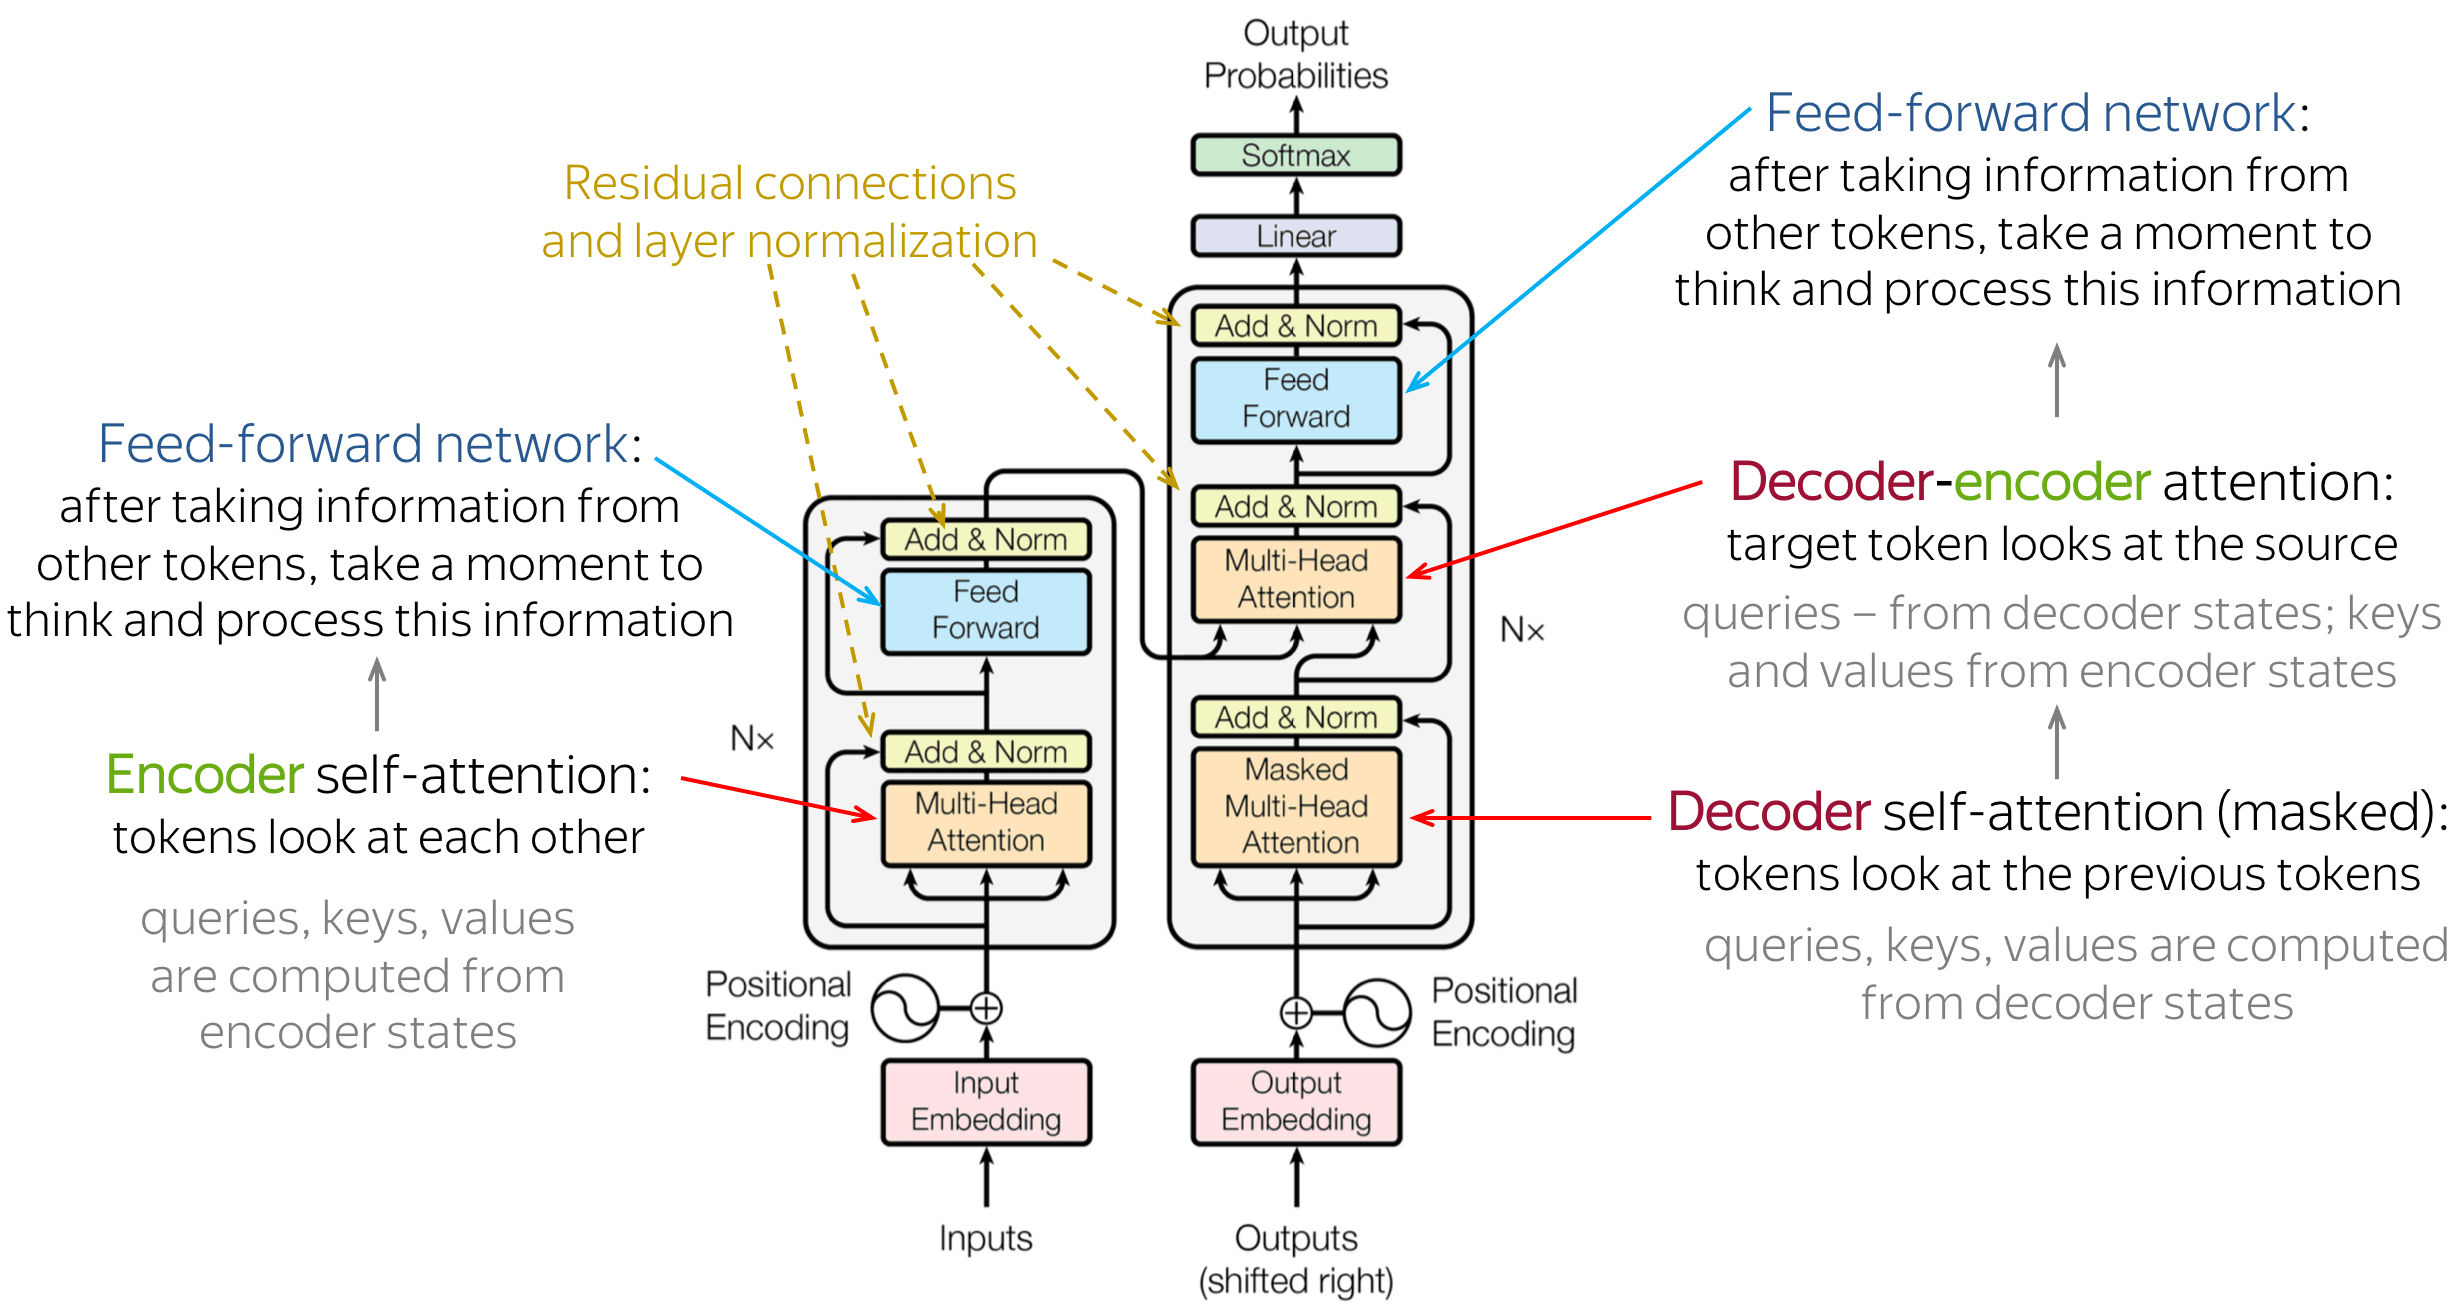

## PositionalEmbedding layers


 Generates a vector representation for each token in the input sequence to incorporate the positional information into the model.

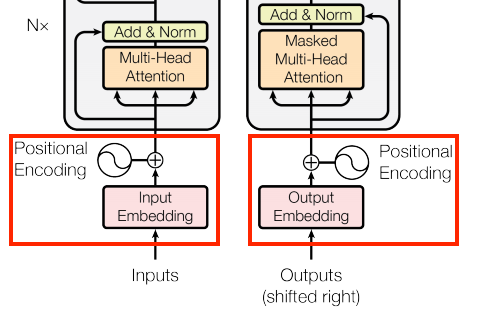

In [2]:
import numpy as np
import tensorflow as tf

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

def positional_encoding(length: int, depth: int):
    """
    Generates a positional encoding for a given length and depth.
    (Generates a matrix of position encodings to provide information about the position of each token in the input sequence.
    This helps the self-attention mechanism in the transformer model to differentiate between different token positions.)

    Args:
        length (int): The length of the input sequence.
        depth (int): The depth that represents the dimensionality of the encoding.

    Returns:
        tf.Tensor: The positional encoding of shape (length, depth).
    """
    depth = depth / 2

    # Create positions and depths matrices
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    # Calculates the angle rates
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)  # Final shape: (length, depth)

    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


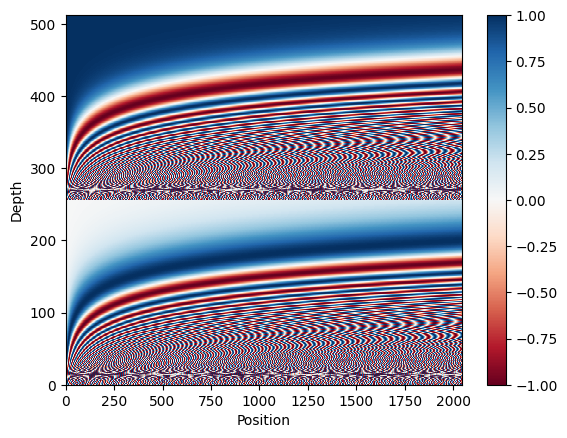

In [3]:
import matplotlib.pyplot as plt

pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

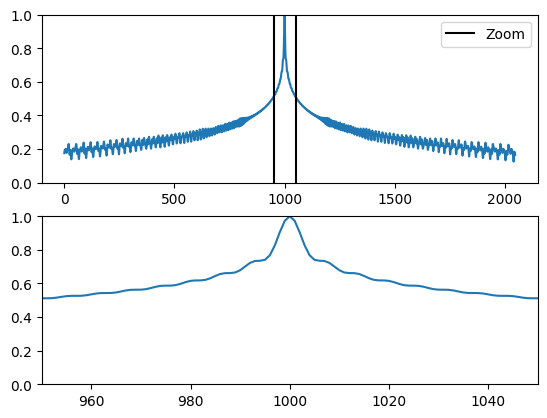

In [4]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d->p', pos_encoding, p).numpy()

plt.subplot(2, 1, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1], color='k', label='Zoom')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(len(dots)), dots)
plt.xlim([950, 1050])
plt.ylim([0, 1])

## PositionalEmbedding layer


Combine positional encoding with token embedding. This layer will be used in Encoder and Decoder layers

In [5]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    A positional embedding layer combines the input embedding with a positional encoding that helps the Transformer
    to understand the relative position of the input tokens. This layer takes the input of tokens and converts them
    into sequence of embeddings vector. Then, it adds the positional encoding to the embeddings.

    Methods:
        compute_mask: Computes the mask to be applied to the embeddings.
        call: Performs the forward pass of the layer.
    """
    def __init__(self, vocab_size: int, d_model: int, embedding: tf.keras.layers.Embedding=None):
        """ Constructor of the PositionalEmbedding layer.

        Args:
            vocab_size (int): The size of the vocabulary. I. e. the number of unique tokens in the input sequence.
            d_model (int): The dimensionality of the embedding vector.
            embedding (tf.keras.layers.Embedding): The custom embedding layer. If None, a default embedding layer will be created.
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) if embedding is None else embedding
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        """ Computes the mask to be applied to the embeddings.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """ Performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input tensor of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of embedding vectors with added positional information. The shape is
                (batch_size, seq_length, d_model).
        """
        x = self.embedding(x)
        length = tf.shape(x)[1]
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [6]:
vocab_size = 1000
d_model = 512

embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_input = np.random.randint(0, vocab_size, size=(1, 100))

output = embedding_layer(random_input)
print("random_input shape", random_input.shape)
print("PositionalEmbedding output", output.shape)

random_input shape (1, 100)
PositionalEmbedding output (1, 100, 512)


## Add & Norm

Placed after each attention layer, this layer is responsible for adding the residual connection and applying layer normalization.

=> Helps with gradient flow during training and enhancing the stability and performance of the model.

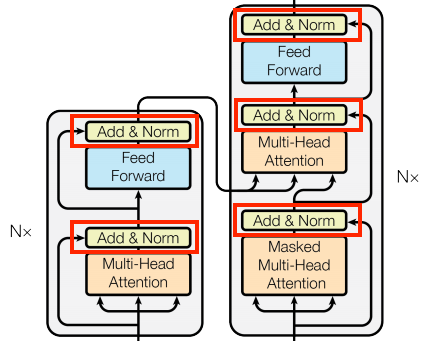

## BaseAttention layer

Core component of the Transformer model. It enables the model to focus on the relevant parts of the input sequence when processing each token.

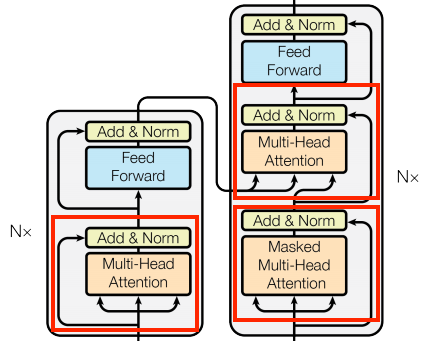

In [7]:
class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.
    It is used as a base class for the GlobalSelfAttention, CausalSelfAttention and CrossAttention layers.
    And it is not intended to be used directly.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """ Constructor of the BaseAttention layer.

        Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e. g.
                        num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## CrossAttention layer: Decoder-encoder attention

Calculate the attention weights between the encoder and decoder sequences. The query vectors are taken from the decoder, while the key and value vectors are taken from the encoder. Using this method, the decoder can concentrate on the essential sections of the input sequence while producing a token for each position.

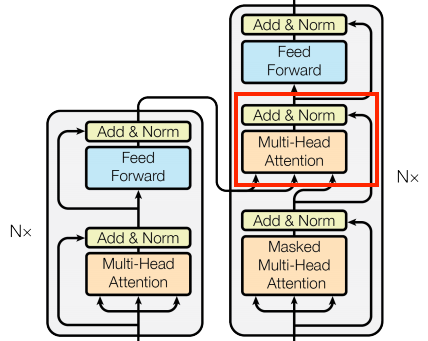

In [8]:
class CrossAttention(BaseAttention):
    """
    A class that implements the cross-attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the cross-attention operation.

        Args:
            x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
            context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [9]:
encoder_vocab_size = 1000
decoder_vocab_size = 1100
d_model = 512

encoder_embedding_layer = PositionalEmbedding(encoder_vocab_size, d_model)
decoder_embedding_layer = PositionalEmbedding(decoder_vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))
random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)
decoder_embeddings = decoder_embedding_layer(random_decoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)
print("decoder_embeddings shape", decoder_embeddings.shape)

cross_attention_layer = CrossAttention(num_heads=2, key_dim=512)
cross_attention_output = cross_attention_layer(decoder_embeddings, encoder_embeddings)

print("cross_attention_output shape", cross_attention_output.shape)

encoder_embeddings shape (1, 100, 512)
decoder_embeddings shape (1, 110, 512)
cross_attention_output shape (1, 110, 512)


## GlobalSelfAttention layer: Encoder self-attention


Processing the context (encoder input) sequence and propagating information along its length

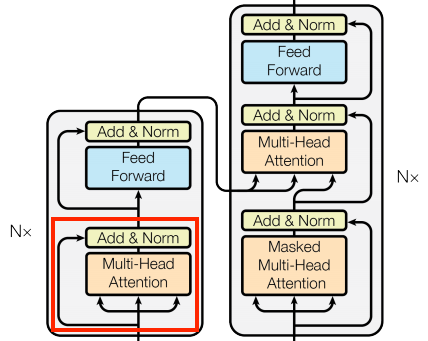

In [10]:
class GlobalSelfAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the global self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [11]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

cross_attention_layer = GlobalSelfAttention(num_heads=2, key_dim=512)
cross_attention_output = cross_attention_layer(encoder_embeddings)

print("global_self_attention_output shape", cross_attention_output.shape)

encoder_embeddings shape (1, 100, 512)
global_self_attention_output shape (1, 100, 512)


## CausalSelfAttention layer: Decoder self-attention


Processing the target (decoder input) sequence and propagating information along its length.

But the CausalSelfAttention layer differs from GlobalSelfAttention because it prevents leftward information flow in the decoder. The causal mask prevents each location from accessing any locations that come after it, ensuring that it only has access to those that come before it.

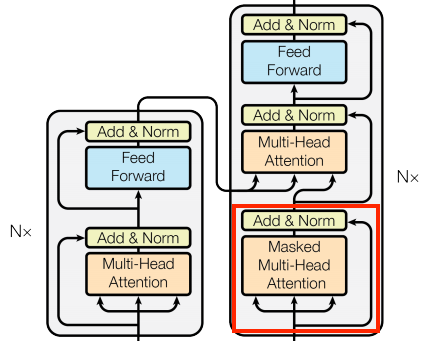

In [12]:
class CausalSelfAttention(BaseAttention):
    """
    Call self attention on the input sequence, ensuring that each position in the
    output depends only on previous positions (i.e. a causal model).

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the causal self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [13]:
decoder_vocab_size = 1100
d_model = 512

decoder_embedding_layer = PositionalEmbedding(decoder_vocab_size, d_model)

random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

decoder_embeddings = decoder_embedding_layer(random_decoder_input)

print("decoder_embeddings shape", decoder_embeddings.shape)

causal_self_attention_layer = CausalSelfAttention(num_heads=2, key_dim=512)
causal_self_attention_output = causal_self_attention_layer(decoder_embeddings)

print("causal_self_attention_output shape", causal_self_attention_output.shape)

out1 = causal_self_attention_layer(decoder_embedding_layer(random_decoder_input[:, :50])) # Only the first 50 tokens beffore applying the embedding layer
out2 = causal_self_attention_layer(decoder_embedding_layer(random_decoder_input)[:, :50]) # Only the first 50 tokens after applying the embedding layer

diff = tf.reduce_max(tf.abs(out1 - out2)).numpy()

print("Difference between the two outputs:", diff)

decoder_embeddings shape (1, 110, 512)
causal_self_attention_output shape (1, 110, 512)
Difference between the two outputs: 0.0


## FeedForward layer


Comprises two dense layers that are individually and uniformly applied to every position.

Primarily used to transform the representation of the input sequence into a more suitable form for the task at hand. This is achieved by applying a linear transformation followed by a non-linear activation function.

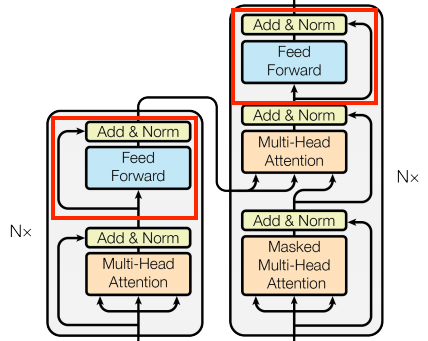

In [14]:
class FeedForward(tf.keras.layers.Layer):
    """
    A class that implements the feed-forward layer.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        seq (tf.keras.Sequential): The sequential layer that contains the feed-forward layers. It applies the two feed-forward layers and the dropout layer.
        add (tf.keras.layers.Add): The Add layer.
        layer_norm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    """
    def __init__(self, d_model: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the FeedForward layer.

        Args:
            d_model (int): The dimensionality of the model.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the feed-forward operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [15]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(encoder_vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

feed_forward_layer = FeedForward(d_model, dff=2048)
feed_forward_output = feed_forward_layer(encoder_embeddings)

print("feed_forward_output shape", feed_forward_output.shape)

encoder_embeddings shape (1, 100, 512)
feed_forward_output shape (1, 100, 512)


## Encoder


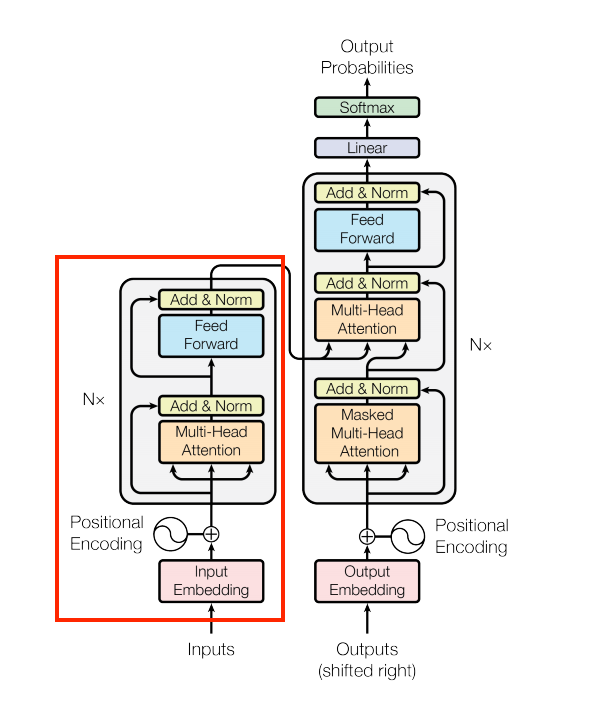

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Encoder. Usually there are multiple layers stacked on top of each other.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        self_attention (GlobalSelfAttention): The global self-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the EncoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
            )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [17]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(encoder_vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

encoder_layer = EncoderLayer(d_model, num_heads=2, dff=2048)

encoder_layer_output = encoder_layer(encoder_embeddings)

print("encoder_layer_output shape", encoder_layer_output.shape)

encoder_embeddings shape (1, 100, 512)
encoder_layer_output shape (1, 100, 512)


In [18]:
class Encoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Encoder. This layer is mostly used in the Transformer models
    for natural language processing tasks, such as machine translation, text summarization or text classification.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the encoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        enc_layers (list): The list of encoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Encoder.

        Args:
            num_layers (int): The number of layers in the encoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.pos_embedding(x)
        # here x has shape `(batch_size, seq_len, d_model)`

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [19]:
encoder_vocab_size = 1000
d_model = 512

encoder = Encoder(num_layers=2, d_model=d_model, num_heads=2, dff=2048, vocab_size=encoder_vocab_size)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_output = encoder(random_encoder_input)

print("random_encoder_input shape", random_encoder_input.shape)
print("encoder_output shape", encoder_output.shape)

random_encoder_input shape (1, 100)
encoder_output shape (1, 100, 512)


## Decoder


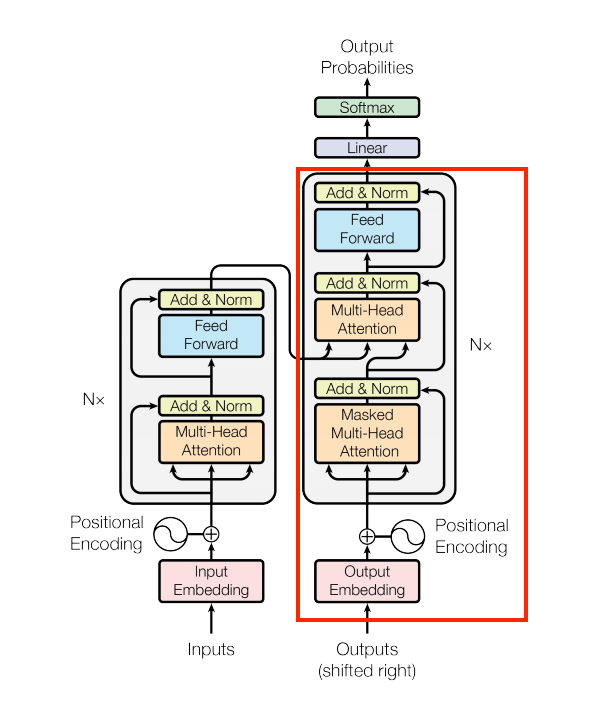

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Decoder. Usually there are multiple layers stacked on top of each other.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        causal_self_attention (CausalSelfAttention): The causal self-attention layer.
        cross_attention (CrossAttention): The cross-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the DecoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model). x is usually the output of the previous decoder layer.
            context (tf.Tensor): The context sequence of shape (batch_size, seq_length, d_model). Context is usually the output of the encoder.
        """
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [21]:
# Test DecoderLayer layer
decoder_vocab_size = 1000
d_model = 512
dff = 2048
num_heads = 8

decoder_layer = DecoderLayer(d_model, num_heads, dff)

random_decoderLayer_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

decoder_embeddings = encoder_embedding_layer(random_decoderLayer_input)

decoderLayer_output = decoder_layer(decoder_embeddings, encoder_output)

print("random_decoder_input shape", random_decoderLayer_input.shape)
print("decoder_embeddings shape", decoder_embeddings.shape)
print("decoder_output shape", decoderLayer_output.shape)

random_decoder_input shape (1, 110)
decoder_embeddings shape (1, 110, 512)
decoder_output shape (1, 110, 512)


In [22]:
class Decoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Decoder. This layer is mostly used in the Transformer models
    for natural language processing tasks, such as machine translation, text summarization or text classification.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the decoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        dec_layers (list): The list of decoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Decoder.

        Args:
            num_layers (int): The number of layers in the decoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model,
                num_heads=num_heads,
                dff=dff,
                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, target_seq_len).
            context (tf.Tensor): The context sequence of shape (batch_size, input_seq_len, d_model).
        """
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [23]:
# Test decoder layer
decoder_vocab_size = 1000
d_model = 512

decoder_layer = Decoder(num_layers=2, d_model=d_model, num_heads=2, dff=2048, vocab_size=decoder_vocab_size)

random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 100))

decoder_output = decoder_layer(random_decoder_input, encoder_output)

print("random_decoder_input shape", random_decoder_input.shape)
print("decoder_output shape", decoder_output.shape)

random_decoder_input shape (1, 100)
decoder_output shape (1, 100, 512)


## The Transformer


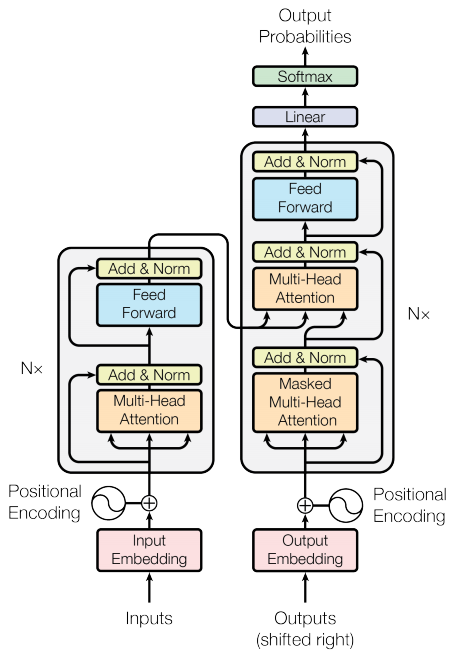

In [24]:
def Transformer(
    input_vocab_size: int,
    target_vocab_size: int,
    encoder_input_size: int = None,
    decoder_input_size: int = None,
    num_layers: int=6,
    d_model: int=512,
    num_heads: int=8,
    dff: int=2048,
    dropout_rate: float=0.1,
    ) -> tf.keras.Model:
    """
    A custom TensorFlow model that implements the Transformer architecture.

    Args:
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        encoder_input_size (int): The size of the encoder input sequence.
        decoder_input_size (int): The size of the decoder input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of heads in the multi-head attention layer.
        dff (int): The dimensionality of the feed-forward layer.
        dropout_rate (float): The dropout rate.

    Returns:
        A TensorFlow Keras model.
    """
    inputs = [
        tf.keras.layers.Input(shape=(encoder_input_size,), dtype=tf.int64),
        tf.keras.layers.Input(shape=(decoder_input_size,), dtype=tf.int64)
        ]

    encoder_input, decoder_input = inputs

    encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(encoder_input)
    decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)(decoder_input, encoder)

    output = tf.keras.layers.Dense(target_vocab_size)(decoder)

    return tf.keras.Model(inputs=inputs, outputs=output)


In [25]:
encoder_input_size = 100
decoder_input_size = 110

encoder_vocab_size = 1000
decoder_vocab_size = 1000

model = Transformer(
    input_vocab_size=encoder_vocab_size,
    target_vocab_size=decoder_vocab_size,
    encoder_input_size=encoder_input_size,
    decoder_input_size=decoder_input_size,
    num_layers=2,
    d_model=512,
    num_heads=2,
    dff=512,
    dropout_rate=0.1)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 encoder_1 (Encoder)         (None, 100, 512)             5768192   ['input_1[0][0]']             
                                                                                                  
 decoder_1 (Decoder)         (None, 110, 512)             9971712   ['input_2[0][0]',             
                                                                     'encoder_1[0][0]']       

## OPUS Dataset
1 000 000 sentences in English and Spanish.

https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-es/


In [26]:
import os
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup

# URL to the directory containing the files to be downloaded
language = "en-es"
url = f"https://data.statmt.org/opus-100-corpus/v1.0/supervised/{language}/"
save_directory = f"./Datasets/{language}"

# Create the save directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML response
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the anchor tags in the HTML
links = soup.find_all('a')

# Extract the href attribute from each anchor tag
file_links = [link['href'] for link in links if '.' in link['href']]

# Download each file
for file_link in tqdm(file_links):
    file_url = url + file_link
    save_path = os.path.join(save_directory, file_link)

    print(f"Downloading {file_url}")

    # Send a GET request for the file
    file_response = requests.get(file_url)
    if file_response.status_code == 404:
        print(f"Could not download {file_url}")
        continue

    # Save the file to the specified directory
    with open(save_path, 'wb') as file:
        file.write(file_response.content)

    print(f"Saved {file_link}")

print("All files have been downloaded.")

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:03,  1.63it/s]

Could not download https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-es//opus-100-corpus/v1.0/supervised/


 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]

Saved opus.en-es-dev.en


 43%|████▎     | 3/7 [00:02<00:04,  1.04s/it]

Saved opus.en-es-dev.es


 57%|█████▋    | 4/7 [00:04<00:03,  1.10s/it]

Saved opus.en-es-test.en


 71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]

Saved opus.en-es-test.es


 86%|████████▌ | 6/7 [00:10<00:02,  2.64s/it]

Saved opus.en-es-train.en


100%|██████████| 7/7 [00:16<00:00,  2.41s/it]

Saved opus.en-es-train.es
All files have been downloaded.


In [27]:
!pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.6 MB/s eta 0:00:00


In [28]:
!pip install tf2onnx onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 53.5 MB/s eta 0:00:00


In [29]:
import numpy as np

import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.tensorflow.callbacks import Model2onnx, WarmupCosineDecay

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tokenizers import CustomTokenizer

from mltu.tensorflow.transformer.utils import MaskedAccuracy, MaskedLoss
from mltu.tensorflow.transformer.callbacks import EncDecSplitCallback

In [30]:
import tensorflow as tf

from mltu.tensorflow.transformer.layers import Encoder, Decoder

def Transformer(
    input_vocab_size: int,
    target_vocab_size: int,
    encoder_input_size: int = None,
    decoder_input_size: int = None,
    num_layers: int=6,
    d_model: int=512,
    num_heads: int=8,
    dff: int=2048,
    dropout_rate: float=0.1,
    ) -> tf.keras.Model:
    """
    A custom TensorFlow model that implements the Transformer architecture.

    Args:
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        encoder_input_size (int): The size of the encoder input sequence.
        decoder_input_size (int): The size of the decoder input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of heads in the multi-head attention layer.
        dff (int): The dimensionality of the feed-forward layer.
        dropout_rate (float): The dropout rate.

    Returns:
        A TensorFlow Keras model.
    """
    inputs = [
        tf.keras.layers.Input(shape=(encoder_input_size,), dtype=tf.int64),
        tf.keras.layers.Input(shape=(decoder_input_size,), dtype=tf.int64)
        ]

    encoder_input, decoder_input = inputs

    encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(encoder_input)
    decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)(decoder_input, encoder)

    output = tf.keras.layers.Dense(target_vocab_size)(decoder)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [31]:
import os
from datetime import datetime

from mltu.configs import BaseModelConfigs


class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join(
            "Models/09_translation_transformer",
            datetime.strftime(datetime.now(), "%Y%m%d%H%M"),
        )
        self.num_layers = 4
        self.d_model = 128
        self.num_heads = 8
        self.dff = 512
        self.dropout_rate = 0.1
        self.batch_size = 16
        self.train_epochs = 50
        # CustomSchedule parameters
        self.init_lr = 0.00001
        self.lr_after_warmup = 0.0005
        self.final_lr = 0.0001
        self.warmup_epochs = 2
        self.decay_epochs = 18

configs = ModelConfigs()


In [32]:
# Path to dataset
en_training_data_path = "Datasets/en-es/opus.en-es-train.en"
en_validation_data_path = "Datasets/en-es/opus.en-es-dev.en"
es_training_data_path = "Datasets/en-es/opus.en-es-train.es"
es_validation_data_path = "Datasets/en-es/opus.en-es-dev.es"

In [33]:
def read_files(path):
    with open(path, "r", encoding="utf-8") as f:
        en_train_dataset = f.read().split("\n")[:-1]
    return en_train_dataset

en_training_data = read_files(en_training_data_path)
en_validation_data = read_files(en_validation_data_path)
es_training_data = read_files(es_training_data_path)
es_validation_data = read_files(es_validation_data_path)



In [34]:
len(es_training_data)

1000000

In [35]:
# Consider only sentences with length <= 500
max_lenght = 50
train_dataset = [[es_sentence, en_sentence] for es_sentence, en_sentence in zip(es_training_data, en_training_data) if len(es_sentence) <= max_lenght and len(en_sentence) <= max_lenght]
val_dataset = [[es_sentence, en_sentence] for es_sentence, en_sentence in zip(es_validation_data, en_validation_data) if len(es_sentence) <= max_lenght and len(en_sentence) <= max_lenght]

# Limit the training dataset to the first 40,000 examples
train_dataset_limited = train_dataset[:40000]

# Unpack the limited dataset back into Spanish and English lists
es_training_data, en_training_data = zip(*train_dataset_limited)

# es_training_data, en_training_data = zip(*train_dataset)
es_validation_data, en_validation_data = zip(*val_dataset)

In [36]:
len(es_training_data)

40000

In [37]:
len(en_validation_data)

1051

In [38]:
# prepare spanish tokenizer, this is the input language
tokenizer = CustomTokenizer(char_level=True)
tokenizer.fit_on_texts(es_training_data)
tokenizer.save(configs.model_path + "/tokenizer.json")

# prepare english tokenizer, this is the output language
detokenizer = CustomTokenizer(char_level=True)
detokenizer.fit_on_texts(en_training_data)
detokenizer.save(configs.model_path + "/detokenizer.json")

Fitting tokenizer: 100%|██████████| 40000/40000 [00:00<00:00, 151865.88it/s]


In [39]:
tokenized_sentence = detokenizer.texts_to_sequences(["Hello world, how are you?"])[0]
print(tokenized_sentence)

detokenized_sentence = detokenizer.detokenize([tokenized_sentence], remove_start_end=False)
print(detokenized_sentence)

detokenized_sentence = detokenizer.detokenize([tokenized_sentence])
print(detokenized_sentence)

[33, 51, 48, 55, 55, 58, 3, 66, 58, 61, 55, 47, 15, 3, 51, 58, 66, 3, 44, 61, 48, 3, 68, 58, 64, 36, 32]
['<start>hello world, how are you?<eos>']
['hello world, how are you?']


In [40]:
configs.model_path

'Models/09_translation_transformer/202403031227'

In [41]:
def preprocess_inputs(data_batch, label_batch):
    # Initialize arrays to store encoder input, decoder input, and decoder output
    encoder_input = np.zeros((len(data_batch), tokenizer.max_length)).astype(np.int64)
    decoder_input = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)
    decoder_output = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)

    # Convert text data to tokens using tokenizer and detokenizer
    data_batch_tokens = tokenizer.texts_to_sequences(data_batch)
    label_batch_tokens = detokenizer.texts_to_sequences(label_batch)

    for index, (data, label) in enumerate(zip(data_batch_tokens, label_batch_tokens)):
        encoder_input[index][:len(data)] = data
        decoder_input[index][:len(label)-1] = label[:-1] # Drop the [END] tokens
        decoder_output[index][:len(label)-1] = label[1:] # Drop the [START] tokens

    return (encoder_input, decoder_input), decoder_output

In sequence-to-sequence models like the one being implemented here, the "START" and "END" tokens are used to denote the beginning and end of a sequence, respectively. These tokens are added to the target sequences during training to indicate to the model when to start and stop generating output.

During training, the model is trained to predict the next token in the sequence given the preceding tokens. If the "START" and "END" tokens were included in the decoder input and output sequences as regular tokens, the model might learn to generate them predictably without properly capturing the underlying translation task. This could lead to suboptimal performance and issues like the model always generating the same starting and ending tokens regardless of the input.

By removing the "START" and "END" tokens from the decoder input and output sequences, we ensure that the model learns to generate translations without relying on these special tokens. The decoder input sequence is shifted by one token so that the model learns to predict the next token in the sequence based on the preceding tokens, excluding the "START" token. Similarly, the decoder output sequence is shifted by one token to match the predictions made by the model, excluding the "END" token.

In summary, removing the "START" and "END" tokens from the decoder input and output sequences helps the model learn to generate translations more effectively by focusing on the actual content of the sequences rather than relying on specific markers for sequence generation.

In [42]:
# Sample sentence pair
sample_index = 0  # Change this to visualize different samples
sample_es_sentence = es_training_data[sample_index]
sample_en_sentence = en_training_data[sample_index]

# Preprocess the sample
(encoder_input, decoder_input), decoder_output = preprocess_inputs([sample_es_sentence], [sample_en_sentence])

# Visualize the results
print("Sample Spanish sentence:", sample_es_sentence)
print("Sample English sentence:", sample_en_sentence)
print("\nEncoder Input:")
print(encoder_input)
print("\nDecoder Input:")
print(decoder_input)
print("\nDecoder Output:")
print(decoder_output)

Sample Spanish sentence: Fueron los asbestos aquí. ¡Eso es lo que ocurrió!
Sample English sentence: It was the asbestos in here, that's what did it!

Encoder Input:
[[ 33  49  64  48  61  58  57   3  55  58  62   3  44  62  45  48  62  63
   58  62   3  44  60  64 106  17   3  76  48  62  58   3  48  62   3  55
   58   3  60  64  48   3  58  46  64  61  61  52 110   4  32   0]]

Decoder Input:
[[33 52 63  3 66 44 62  3 63 51 48  3 44 62 45 48 62 63 58 62  3 52 57  3
  51 48 61 48 15  3 63 51 44 63 10 62  3 66 51 44 63  3 47 52 47  3 52 63
   4  0  0  0]]

Decoder Output:
[[52 63  3 66 44 62  3 63 51 48  3 44 62 45 48 62 63 58 62  3 52 57  3 51
  48 61 48 15  3 63 51 44 63 10 62  3 66 51 44 63  3 47 52 47  3 52 63  4
  32  0  0  0]]


In [43]:
# Create Training Data Provider
train_dataProvider = DataProvider(
    train_dataset,
    batch_size=configs.batch_size,
    batch_postprocessors=[preprocess_inputs],
    use_cache=True,
    )

# Create Validation Data Provider
val_dataProvider = DataProvider(
    val_dataset,
    batch_size=configs.batch_size,
    batch_postprocessors=[preprocess_inputs],
    use_cache=True,
    )

INFO:DataProvider:Skipping Dataset validation...
INFO:DataProvider:Skipping Dataset validation...


In [44]:
for data_batch in train_dataProvider:
    (encoder_inputs, decoder_inputs), decoder_outputs = data_batch

    encoder_inputs_str = tokenizer.detokenize(encoder_inputs)
    decoder_inputs_str = detokenizer.detokenize(decoder_inputs, remove_start_end=False)
    decoder_outputs_str = detokenizer.detokenize(decoder_outputs, remove_start_end=False)
    print(encoder_inputs_str)
    print(decoder_inputs_str)
    print(decoder_outputs_str)

    break

['fueron los asbestos aquí. ¡eso es lo que ocurrió!', 'me voy de aquí.', 'una vez, juro que cagué una barra de tiza.', 'y prefiero mudarme, ¿entiendes?', '- gracias.', 'debes ayudarme.', '¡por la mierda!', 'así lo decidí, pueden quedarse si quieren.', 'norman.', '- yo no soy estúpido.', 'es algo sin complicaciones.', '¡no!', 'no.', 'te diré algo que me dijo mi padre.', 'http://www.madeira.ji.cz/', '¿qué?']
["<start>it was the asbestos in here, that's what did it!", "<start>i'm out of here.", '<start>one time, i swear i pooped out a stick of chalk.', '<start>and i will move, do you understand me?', '<start>- thank you, my lord.', '<start>you have to help me.', '<start>fuck this!', '<start>you can stay if you want.', '<start>norman.', "<start>- i'm not stupid.", "<start>it's uncomplicated.", '<start>no!', '<start>no.', "<start>- mm. i'll tell you something my father told me.", '<start>http://www.vodniraj.cz/bazen.asp', '<start>what?']
["it was the asbestos in here, that's what did it!<eo

In [45]:
# Create TensorFlow Transformer Model
transformer = Transformer(
    num_layers=configs.num_layers,
    d_model=configs.d_model,
    num_heads=configs.num_heads,
    dff=configs.dff,
    input_vocab_size=len(tokenizer)+1,
    target_vocab_size=len(detokenizer)+1,
    dropout_rate=configs.dropout_rate,
    encoder_input_size=tokenizer.max_length,
    decoder_input_size=detokenizer.max_length
    )

transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 52)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 52)]                 0         []                            
                                                                                                  
 encoder_2 (Encoder)         (None, 52, 128)              2659456   ['input_3[0][0]']             
                                                                                                  
 decoder_2 (Decoder)         (None, 52, 128)              4771328   ['input_4[0][0]',             
                                                                     'encoder_2[0][0]']     

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=configs.init_lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
transformer.compile(
    loss=MaskedLoss(),
    optimizer=optimizer,
    metrics=[MaskedAccuracy()],
    run_eagerly=False
    )

In [47]:
# Define callbacks
warmupCosineDecay = WarmupCosineDecay(
    lr_after_warmup=configs.lr_after_warmup,
    final_lr=configs.final_lr,
    warmup_epochs=configs.warmup_epochs,
    decay_epochs=configs.decay_epochs,
    initial_lr=configs.init_lr,
    )
earlystopper = EarlyStopping(monitor="val_masked_accuracy", patience=5, verbose=1, mode="max")
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/models/transformer_translation/model.h5", monitor="val_masked_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=False)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_masked_accuracy", factor=0.9, min_delta=1e-10, patience=2, verbose=1, mode="max")
model2onnx = Model2onnx(f"/content/drive/MyDrive/models/transformer_translation/model.h5", metadata={"tokenizer": tokenizer.dict(), "detokenizer": detokenizer.dict()}, save_on_epoch_end=False)
encDecSplitCallback = EncDecSplitCallback(configs.model_path, encoder_metadata={"tokenizer": tokenizer.dict()}, decoder_metadata={"detokenizer": detokenizer.dict()})

In [ ]:
# Train the model
transformer.fit(
    train_dataProvider,
    validation_data=val_dataProvider,
    epochs=configs.train_epochs,
    callbacks=[
        warmupCosineDecay,
        checkpoint,
        reduceLROnPlat,
        model2onnx,
        encDecSplitCallback
        ]
    )

Epoch 1/50
38952/38952 [==============================] - ETA: 0s - loss: 1.1875 - masked_accuracy: 0.6526
Epoch 1: val_masked_accuracy improved from -inf to 0.74901, saving model to /content/drive/MyDrive/models/transformer_translation/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38952/38952 [==============================] - 2033s 51ms/step - loss: 1.1875 - masked_accuracy: 0.6526 - val_loss: 0.8930 - val_masked_accuracy: 0.7490 - lr: 2.5500e-04
Epoch 2/50
38952/38952 [==============================] - ETA: 0s - loss: 0.8978 - masked_accuracy: 0.7441
Epoch 2: val_masked_accuracy improved from 0.74901 to 0.76816, saving model to /content/drive/MyDrive/models/transformer_translation/model.h5
38952/38952 [==============================] - 1977s 51ms/step - loss: 0.8978 - masked_accuracy: 0.7441 - val_loss: 0.8307 - val_masked_accuracy: 0.7682 - lr: 5.0000e-04
Epoch 3/50
38951/38952 [============================>.] - ETA: 0s - loss: 0.7931 - masked_accuracy: 0.7758
Epoch 3: val_masked_accuracy improved from 0.76816 to 0.78414, saving model to /content/drive/MyDrive/models/transformer_translation/model.h5
38952/38952 [==============================] - 1974s 51ms/step - loss: 0.7931 - masked_accuracy: 0.7758 - val_loss: 0.7831 - val_masked_accuracy: 0.7841 - lr: 5.0

In [52]:
!pip install nltk

In [49]:
!gdown https://drive.google.com/uc?id=1N25HEAV2DfdQWIgoezv9Nk1Zv0IbTfEF

Downloading...
From: https://drive.google.com/uc?id=1N25HEAV2DfdQWIgoezv9Nk1Zv0IbTfEF
To: /content/model.onnx
100% 50.8M/50.8M [00:00<00:00, 89.7MB/s]


In [59]:
import numpy as np
import time
from nltk.translate.bleu_score import corpus_bleu
from mltu.tokenizers import CustomTokenizer
from mltu.inferenceModel import OnnxInferenceModel

class PtEnTranslator(OnnxInferenceModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.new_inputs = self.model.get_inputs()
        self.tokenizer = CustomTokenizer.load(self.metadata["tokenizer"])
        self.detokenizer = CustomTokenizer.load(self.metadata["detokenizer"])

    def predict(self, sentence):
        start = time.time()
        tokenized_sentence = self.tokenizer.texts_to_sequences([sentence])[0]
        encoder_input = np.pad(tokenized_sentence, (0, self.tokenizer.max_length - len(tokenized_sentence)), constant_values=0).astype(np.int64)

        tokenized_results = [self.detokenizer.start_token_index]
        for index in range(self.detokenizer.max_length - 1):
            decoder_input = np.pad(tokenized_results, (0, self.detokenizer.max_length - len(tokenized_results)), constant_values=0).astype(np.int64)
            input_dict = {
                self.model._inputs_meta[0].name: np.expand_dims(encoder_input, axis=0),
                self.model._inputs_meta[1].name: np.expand_dims(decoder_input, axis=0),
            }
            preds = self.model.run(None, input_dict)[0] # preds shape (1, 206, 29110)
            pred_results = np.argmax(preds, axis=2)
            tokenized_results.append(pred_results[0][index])

            if tokenized_results[-1] == self.detokenizer.end_token_index:
                break

        results = self.detokenizer.detokenize([tokenized_results])
        return results[0], time.time() - start

def read_files(path):
    with open(path, "r", encoding="utf-8") as f:
        en_train_dataset = f.read().split("\n")[:-1]
    return en_train_dataset

# Path to dataset
en_validation_data_path = "Datasets/en-es/opus.en-es-dev.en"
es_validation_data_path = "Datasets/en-es/opus.en-es-dev.es"

en_validation_data = read_files(en_validation_data_path)
es_validation_data = read_files(es_validation_data_path)

# Consider only sentences with length <= 500
max_lenght = 500
val_examples = [[es_sentence, en_sentence] for es_sentence, en_sentence in zip(es_validation_data, en_validation_data) if len(es_sentence) <= max_lenght and len(en_sentence) <= max_lenght]

translator = PtEnTranslator("model.onnx")

references = []  # List to store the actual English sentences
hypotheses = []  # List to store the predicted English sentences by your model

try:
  val_dataset = []
  for es, en in val_examples:
      results, duration = translator.predict(es)
      print("Spanish:     ", es.lower())
      print("English:     ", en.lower())
      print("English pred:", results)
      print(duration)
      references.append([en.lower().split()])  # BLEU expects a list of references
      hypotheses.append(results.split())
      print()

except:
  # Calculate BLEU score
  bleu_score = corpus_bleu(references, hypotheses)
  print(f'BLEU score: {bleu_score*100:.2f}')

# Calculate BLEU score
bleu_score = corpus_bleu(references, hypotheses)
print(f'BLEU score: {bleu_score*100:.2f}')

Spanish:      no recuerdo por qué fue la pelea.
English:      i don't even remember what the fight was about.
English pred: i don't remember why it was the fight.
15.82029414176941

Spanish:      estos son los sitios en que cada congreso ha tenido lugar:
English:      here are the sites of each of those that have taken place:
English pred: these are the places in which each congress has taken place:
25.50107479095459

Spanish:      sí. soy el hombre que mató a barbanegra.
English:      i'm the man who killed blackbeard.
English pred: i'm the man who killed barbanegra.
14.225972652435303

Spanish:      no te hagas el inteligente.
English:      don't get smart.
English pred: don't make the smart one.
9.63658332824707

Spanish:      ¿existe un límite de cuándo se padece y cuándo no?
English:      is there an exact moment in the life of a soldier before which he is not suffering from shell-shock and after which he is?
English pred: is there a limit of when he suffers and when not?
21.35283